# Final Project: Benchmarking Transformer Based Models for LGBT Hate Speech

## 0. Setup

### 0.1. Libraries and Helper Functions

In [ ]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -q datasets
!pip install -q evaluate
!pip install emoji==0.6.0
!pip install --upgrade transformers

In [ ]:
!pip install optuna

In [ ]:
#@title 1. Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import transformers
import evaluate

from datasets import load_dataset, Dataset, DatasetDict
from torchinfo import summary

from collections import Counter
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from transformers import pipeline
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Data Setup


We *use* the HuggingFace HateXPlain dataset: https://huggingface.co/datasets/Hate-speech-CNERG/hatexplain

In [ ]:
# Load the HateXplain dataset
data= load_dataset("Hate-speech-CNERG/hatexplain", trust_remote_code=True)

# Access the train, validation, and test splits
train_dataset = data['train']
validation_dataset = data['validation']
test_dataset = data['test']

#### Preprocessing

In [ ]:
def add_majority_speech_col(data):
  majority_labels = []
  for annotator_set in data['annotators']:
      labels = annotator_set['label']
      majority = Counter(labels).most_common(1)[0][0]
      majority_labels.append(majority)

  data = data.add_column(f"majority_speech", majority_labels)
  return data

In [ ]:
def add_majority_target_col(data):
    majority_targets = []
    target_set = []
    # Loop over each row (example) in the dataset
    for annotator_set in data['annotators']:
        target_set = []
        for annotator in annotator_set['target']:
          for target in annotator:
            target_set.append(target)
        majority = Counter(target_set).most_common(1)[0][0]
        majority_targets.append(majority)

    # Add the column once, after collecting all values
    return data.add_column("majority_target", majority_targets)

In [ ]:
def add_sentence_col(data):
    sentence_set = []

    # Loop over each row (example) in the dataset
    for example in data:
        sentence = " ".join(example['post_tokens'])  # Join tokens into a sentence
        sentence_set.append(sentence)

    # Add the new column
    return data.add_column("sentence", sentence_set)

In [ ]:
# Extract the majority target column
train_dataset = add_majority_target_col(train_dataset)
validation_dataset = add_majority_target_col(validation_dataset)
test_dataset = add_majority_target_col(test_dataset)

In [ ]:
# Extract the majority labeled column in terms of speech type detected
train_dataset = add_majority_speech_col(train_dataset)
validation_dataset = add_majority_speech_col(validation_dataset)
test_dataset = add_majority_speech_col(test_dataset)

In [ ]:
filtered_train_dataset = train_dataset.filter(
    lambda example: example['majority_target'].lower() == "homosexual"
)

filtered_test_dataset = test_dataset.filter(
    lambda example: example['majority_target'].lower() == "homosexual"
)

filtered_val_dataset = validation_dataset.filter(
    lambda example: example['majority_target'].lower() == "homosexual"
)

print("filtered train:", len(filtered_train_dataset))
print("filtered test:", len(filtered_test_dataset))
print("filtered val:", len(filtered_val_dataset))

filtered train: 1270
filtered test: 158
filtered val: 162


Concatenate post_tokens into a sentence

In [ ]:
filtered_train_dataset = add_sentence_col(filtered_train_dataset)
filtered_test_dataset = add_sentence_col(filtered_test_dataset)
filtered_val_dataset = add_sentence_col(filtered_val_dataset)

In [ ]:
print(filtered_train_dataset[0])

{'id': '11200659_gab', 'annotators': {'label': [2, 0, 2], 'annotator_id': [208, 202, 204], 'target': [['Other'], ['Homosexual'], ['Homosexual']]}, 'rationales': [[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]], 'post_tokens': ['i', 'am', 'sure', 'you', 'are', 'totally', 'the', 'alpha', 'faggot', 'at', 'the', 'standard', 'fuckparties'], 'majority_target': 'Homosexual', 'majority_speech': 2, 'sentence': 'i am sure you are totally the alpha faggot at the standard fuckparties'}


## 2. Visualizations

In [ ]:
candidate_labels = ["normal", "offensive", "hatespeech"]
label_map = {0: "normal", 1: "offensive", 2: "hatespeech"}

### Current State of Dataset
- We filtered so the only target are homosexual

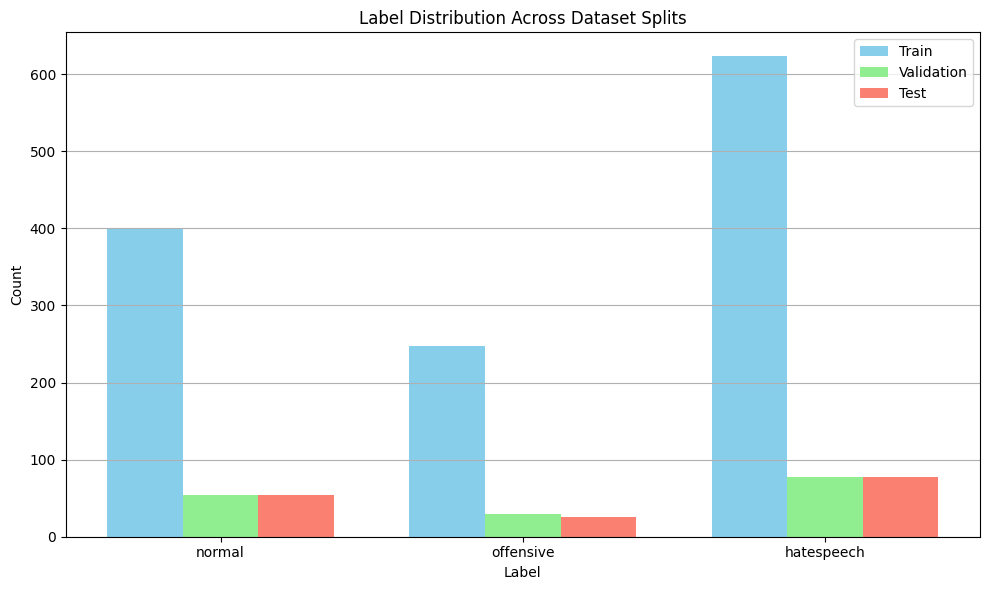

In [ ]:
# Replace these with actual mappings from your dataset
train_labels = [label_map[example['majority_speech']] for example in filtered_train_dataset]
val_labels = [label_map[example['majority_speech']] for example in filtered_val_dataset]
test_labels = [label_map[example['majority_speech']] for example in filtered_test_dataset]

# Count label occurrences
train_dist = Counter(train_labels)
val_dist = Counter(val_labels)
test_dist = Counter(test_labels)

# Human-readable label names
x_labels = [label_map.get(i) for i in range(3)]

# Prepare counts for aligned plotting
train_counts = [train_dist.get(i, 0) for i in x_labels]
val_counts = [val_dist.get(i, 0) for i in x_labels]
test_counts = [test_dist.get(i, 0) for i in x_labels]


# Plotting
x = range(len(x_labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar([i - width for i in x], train_counts, width=width, label='Train', color='skyblue')
plt.bar(x, val_counts, width=width, label='Validation', color='lightgreen')
plt.bar([i + width for i in x], test_counts, width=width, label='Test', color='salmon')

plt.xticks(x, x_labels)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution Across Dataset Splits")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 3. Baseline Models

### 3.1 Baseline Model: Most Frequent Class

In [ ]:
# Gets most common class/label
train_labels = [max(set(annot['label']), key=annot['label'].count) for annot in filtered_train_dataset['annotators']]
majority_class = Counter(train_labels).most_common(1)[0][0]

test_labels = [max(set(annot['label']), key=annot['label'].count) for annot in filtered_test_dataset['annotators']]
naive_predictions = [majority_class] * len(test_labels) # should all be 2 (hatespeech)

most_freq_class_classifier_results = classification_report(test_labels, naive_predictions, target_names=candidate_labels, output_dict=True, zero_division=0)

### 3.2 Baseline Model: RoBERTa-Base Zero-Shot

In [ ]:
# Initialize ZeroShotClassification pipeline with RoBERTa
roberta_base_classifier = pipeline("zero-shot-classification", model="roberta-base", tokenizer="roberta-base")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [ ]:
# Use RoBERTa-Base to predict labels on the test dataset
results = []

for example in tqdm(filtered_test_dataset, desc="Classifying"):
    result = roberta_base_classifier(example['sentence'], candidate_labels)
    results.append({
        "text": example['sentence'],
        "predicted_label": result['labels'][0],
        "scores": dict(zip(result['labels'], result['scores']))
    })

Classifying: 100%|██████████| 158/158 [00:11<00:00, 14.20it/s]


#### Baseline RoBERTa Results

In [ ]:
true_labels = [label_map[example['majority_speech']] for example in filtered_test_dataset]
predicted_labels = [res['predicted_label'] for res in results]
zero_shot_roberta_results = classification_report(true_labels, predicted_labels, output_dict=True, target_names=candidate_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. Fine-Tuned Models

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    # Weighted and overall metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    # Per-label detailed metrics
    report = classification_report(labels, preds, output_dict=True, zero_division=0)

    # Flatten per-class results into one dict
    per_class_metrics = {}
    for label, scores in report.items():
        if label in ["0", "1", "2"]:
            per_class_metrics[f"{label_map[int(label)]}_f1"] = scores["f1-score"]
            per_class_metrics[f"{label_map[int(label)]}_precision"] = scores["precision"]
            per_class_metrics[f"{label_map[int(label)]}_recall"] = scores["recall"]

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": acc,
        **per_class_metrics
    }

In [ ]:
def get_tokenized_dataset(dataset, tokenizer):
    tokenized = dataset.map(
        lambda x: tokenizer(x["sentence"], truncation=True, padding='max_length', max_length=160),
        batched=True
    )
    tokenized = tokenized.rename_column("majority_speech", "labels")
    tokenized = tokenized.remove_columns([col for col in tokenized.column_names if col not in ["input_ids", "attention_mask", "labels"]])
    tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized


### 4.0 RoBERTa

#### Reload Best Model If Restarted

In [ ]:
model_roberta = AutoModelForSequenceClassification.from_pretrained('./roberta-finetuned-best')
tokenizer_roberta = AutoTokenizer.from_pretrained('./roberta-finetuned-best')


# Recreate a Trainer using the loaded model
best_trainer_roberta = Trainer(
    model=model_roberta,
    tokenizer=tokenizer_roberta,
    args=TrainingArguments(output_dir="./temp", report_to="none"),  # minimal setup for evaluation
    compute_metrics=compute_metrics
)

tokenized_test_roberta = get_tokenized_dataset(filtered_test_dataset, tokenizer_roberta)
roberta_results = best_trainer_roberta.evaluate(eval_dataset=tokenized_test_roberta)

<ipython-input-42-ba66e7ee25fc>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer_roberta = Trainer(


#### RoBERTa Optuna hyperparameter serach

In [ ]:
model_name = "roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
#model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize the dataset with RoBERTa tokenizer
tokenized_train_roberta = get_tokenized_dataset(filtered_train_dataset, tokenizer_roberta)
tokenized_val_roberta= get_tokenized_dataset(filtered_val_dataset, tokenizer_roberta)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir="./roberta-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none"
)

trainer_roberta = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train_roberta,
    eval_dataset=tokenized_val_roberta,
    compute_metrics=compute_metrics,
)

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_run_roberta = trainer_roberta.hyperparameter_search(
    direction="maximize",
    n_trials=8,
    compute_objective=lambda metrics: metrics["eval_f1"],
    hp_space=lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1)
    }
)

[I 2025-04-15 04:26:48,678] A new study created in memory with name: no-name-4825f896-a87b-4382-9f48-cf0e11357b9e
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,No log,0.916709,0.479229,0.523627,0.506173,0.506173,0.422222,0.527778,0.351852,0.300000,0.600000,0.200000,0.587629,0.491379,0.730769
2,No log,0.922752,0.496183,0.511195,0.506173,0.506173,0.430108,0.512821,0.370370,0.440000,0.550000,0.366667,0.563536,0.495146,0.653846


[I 2025-04-15 04:28:33,653] Trial 0 finished with value: 0.4961827626949708 and parameters: {'learning_rate': 3.495271474858987e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.06642063764911296}. Best is trial 0 with value: 0.4961827626949708.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,No log,0.894451,0.523917,0.537649,0.530864,0.530864,0.480000,0.521739,0.444444,0.458333,0.611111,0.366667,0.579545,0.520408,0.653846
2,No log,0.886841,0.541734,0.542308,0.543210,0.543210,0.504854,0.530612,0.481481,0.517241,0.535714,0.500000,0.576687,0.552941,0.602564
3,No log,0.924012,0.541593,0.545557,0.549383,0.549383,0.568807,0.563636,0.574074,0.375000,0.500000,0.300000,0.586826,0.550562,0.628205


[I 2025-04-15 04:31:03,464] Trial 1 finished with value: 0.5415929100005901 and parameters: {'learning_rate': 4.87469689561394e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.013618717113142654}. Best is trial 1 with value: 0.5415929100005901.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,No log,0.886026,0.476367,0.513757,0.512346,0.512346,0.614286,0.500000,0.796296,0.166667,0.500000,0.100000,0.500000,0.528571,0.474359
2,No log,0.899035,0.559042,0.581347,0.567901,0.567901,0.516129,0.615385,0.444444,0.489796,0.631579,0.400000,0.615385,0.538462,0.717949


[I 2025-04-15 04:32:50,891] Trial 2 finished with value: 0.5590422548947894 and parameters: {'learning_rate': 2.2519954046293944e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.028469971662982364}. Best is trial 2 with value: 0.5590422548947894.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,No log,0.884560,0.534695,0.561525,0.549383,0.549383,0.596774,0.528571,0.685185,0.341463,0.636364,0.233333,0.566038,0.555556,0.576923
2,No log,0.910405,0.507282,0.530146,0.518519,0.518519,0.474227,0.534884,0.425926,0.400000,0.600000,0.300000,0.571429,0.500000,0.666667


[I 2025-04-15 04:34:40,611] Trial 3 finished with value: 0.5072819505809196 and parameters: {'learning_rate': 3.738321838221434e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.09731587438957838}. Best is trial 2 with value: 0.5590422548947894.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,No log,0.870642,0.555290,0.589936,0.567901,0.567901,0.608000,0.535211,0.703704,0.390244,0.727273,0.266667,0.582278,0.575000,0.589744
2,No log,0.908488,0.513307,0.549685,0.530864,0.530864,0.463158,0.536585,0.407407,0.380952,0.666667,0.266667,0.598930,0.513761,0.717949


[I 2025-04-15 04:36:33,134] Trial 4 finished with value: 0.5133066375584435 and parameters: {'learning_rate': 3.019079179866884e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.0024587608092044968}. Best is trial 2 with value: 0.5590422548947894.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,No log,0.996564,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-15 04:37:13,605] Trial 5 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,No log,0.895221,0.487045,0.549270,0.524691,0.524691,0.561404,0.533333,0.592593,0.121212,0.666667,0.066667,0.576271,0.515152,0.653846


[I 2025-04-15 04:37:53,469] Trial 6 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,No log,0.951663,0.476522,0.433515,0.530864,0.530864,0.578947,0.550000,0.611111,0.000000,0.000000,0.000000,0.588889,0.519608,0.679487


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-15 04:38:33,424] Trial 7 pruned. 


#### Train model with best hyperparameters

In [ ]:
# Fresh training args with best hyperparams
best_training_args = TrainingArguments(
    output_dir="./roberta-finetuned-best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    **best_run_roberta.hyperparameters  # inject the best values
)

# New trainer with best config
best_trainer_roberta = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=tokenized_train_roberta,
    eval_dataset=tokenized_val_roberta,
    compute_metrics=compute_metrics,
)

# Train the model
best_trainer_roberta.train()
best_trainer_roberta.save_model("./roberta-finetuned-best")
tokenizer_roberta.save_pretrained("./roberta-finetuned-best")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.945100,0.886026,0.476367,0.513757,0.512346,0.512346,0.614286,0.500000,0.796296,0.166667,0.500000,0.100000,0.500000,0.528571,0.474359
2,0.796800,0.899035,0.559042,0.581347,0.567901,0.567901,0.516129,0.615385,0.444444,0.489796,0.631579,0.400000,0.615385,0.538462,0.717949


('./roberta-finetuned-best/tokenizer_config.json',
 './roberta-finetuned-best/special_tokens_map.json',
 './roberta-finetuned-best/vocab.json',
 './roberta-finetuned-best/merges.txt',
 './roberta-finetuned-best/added_tokens.json',
 './roberta-finetuned-best/tokenizer.json')

In [ ]:
tokenized_test_roberta = get_tokenized_dataset(filtered_test_dataset, tokenizer_roberta)
roberta_results = best_trainer_roberta.evaluate(eval_dataset=tokenized_test_roberta)

### 4.1 HateBERT

#### Reload Best Model if Restarted

In [ ]:
model_hatebert = AutoModelForSequenceClassification.from_pretrained('./hatebert-finetuned-best')
tokenizer_hatebert = AutoTokenizer.from_pretrained('./hatebert-finetuned-best')

# Recreate a Trainer using the loaded model
best_trainer_hatebert = Trainer(
    model=model_hatebert,
    tokenizer=tokenizer_hatebert,
    args=TrainingArguments(output_dir="./temp", report_to="none"),  # minimal setup for evaluation
    compute_metrics=compute_metrics
)

tokenized_test_hatebert = get_tokenized_dataset(filtered_test_dataset, tokenizer_hatebert)
hatebert_results = best_trainer_hatebert.evaluate(eval_dataset=tokenized_test_hatebert)

<ipython-input-45-5e5580d8e966>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer_hatebert = Trainer(


#### HateBERT Start

In [ ]:
# Define the model and tokenizer
model_name = "GroNLP/hateBERT"
tokenizer_hatebert = AutoTokenizer.from_pretrained(model_name)

tokenized_train_hatebert = get_tokenized_dataset(filtered_train_dataset, tokenizer_hatebert)
tokenized_val_hatebert= get_tokenized_dataset(filtered_val_dataset, tokenizer_hatebert)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# training args
training_args = TrainingArguments(
    output_dir="./hatebert-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)

trainer_hatebert = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train_hatebert,
    eval_dataset=tokenized_val_hatebert,
    compute_metrics=compute_metrics,
)

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### HateBert Optuna hyperparameter search

In [ ]:
best_run_hatebert = trainer_hatebert.hyperparameter_search(
    direction="maximize",
    n_trials=5,
    compute_objective=lambda metrics: metrics["eval_f1"],
    hp_space=lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1)
    }
)

[I 2025-04-15 04:40:36,008] A new study created in memory with name: no-name-9b2e4505-3fcf-4ca2-ae98-4029bbc6949a
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.971400,0.868142,0.536146,0.541135,0.549383,0.549383,0.605042,0.553846,0.666667,0.311111,0.466667,0.233333,0.575000,0.560976,0.589744
2,0.775800,0.881833,0.531310,0.538314,0.537037,0.537037,0.532110,0.527273,0.537037,0.416667,0.555556,0.333333,0.574850,0.539326,0.615385
3,0.585400,0.927786,0.564552,0.566449,0.567901,0.567901,0.568807,0.563636,0.574074,0.461538,0.545455,0.400000,0.601227,0.576471,0.628205
4,0.464400,0.972986,0.547903,0.549691,0.549383,0.549383,0.561404,0.533333,0.592593,0.481481,0.541667,0.433333,0.564103,0.564103,0.564103


[I 2025-04-15 04:43:34,604] Trial 0 finished with value: 0.547902678506967 and parameters: {'learning_rate': 2.638101640147654e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.05566818550622757}. Best is trial 0 with value: 0.547902678506967.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.986300,0.883039,0.536499,0.571058,0.555556,0.555556,0.563636,0.553571,0.574074,0.307692,0.666667,0.200000,0.605714,0.546392,0.679487
2,0.815700,0.873103,0.528487,0.539128,0.537037,0.537037,0.523364,0.528302,0.518519,0.391304,0.562500,0.300000,0.584795,0.537634,0.641026
3,0.695000,0.865611,0.541170,0.551768,0.549383,0.549383,0.583333,0.530303,0.648148,0.391304,0.562500,0.300000,0.569620,0.562500,0.576923


[I 2025-04-15 04:45:52,117] Trial 1 finished with value: 0.5411698159359138 and parameters: {'learning_rate': 2.1752476884593742e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.03174846543767401}. Best is trial 0 with value: 0.547902678506967.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.928200,0.876522,0.534822,0.542116,0.537037,0.537037,0.550000,0.500000,0.611111,0.470588,0.571429,0.400000,0.549020,0.560000,0.538462
2,0.644000,1.006737,0.525197,0.529012,0.524691,0.524691,0.491228,0.466667,0.518519,0.518519,0.583333,0.466667,0.551282,0.551282,0.551282


[I 2025-04-15 04:47:37,130] Trial 2 finished with value: 0.5251967366977114 and parameters: {'learning_rate': 4.2823305350803846e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.03867665773957534}. Best is trial 0 with value: 0.547902678506967.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.942200,0.866061,0.540820,0.545498,0.543210,0.543210,0.556522,0.524590,0.592593,0.470588,0.571429,0.400000,0.556962,0.550000,0.564103
2,0.688000,0.954603,0.512231,0.516957,0.512346,0.512346,0.500000,0.467742,0.537037,0.490566,0.565217,0.433333,0.529032,0.532468,0.525641
3,0.369400,1.206441,0.536265,0.536782,0.537037,0.537037,0.518519,0.518519,0.518519,0.500000,0.538462,0.466667,0.562500,0.548780,0.576923
4,0.184800,1.318607,0.536505,0.538019,0.537037,0.537037,0.543860,0.516667,0.574074,0.500000,0.538462,0.466667,0.545455,0.552632,0.538462


[I 2025-04-15 04:50:33,794] Trial 3 finished with value: 0.5365054049264576 and parameters: {'learning_rate': 4.595966575513792e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.0921539345815214}. Best is trial 0 with value: 0.547902678506967.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.928000,0.898005,0.486883,0.507841,0.506173,0.506173,0.562500,0.486486,0.666667,0.250000,0.500000,0.166667,0.525641,0.525641,0.525641
2,0.626100,1.137129,0.491809,0.503159,0.506173,0.506173,0.461538,0.480000,0.444444,0.318182,0.500000,0.233333,0.579545,0.520408,0.653846
3,0.254600,1.674393,0.531576,0.532982,0.537037,0.537037,0.538462,0.560000,0.518519,0.384615,0.454545,0.333333,0.583333,0.544444,0.628205
4,0.092800,2.146912,0.517565,0.519809,0.518519,0.518519,0.517241,0.483871,0.555556,0.436364,0.480000,0.400000,0.549020,0.560000,0.538462


[I 2025-04-15 04:53:50,596] Trial 4 finished with value: 0.5175646480582249 and parameters: {'learning_rate': 4.367224972482427e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.021793513833736913}. Best is trial 0 with value: 0.547902678506967.


In [ ]:
# Best hyperparams
best_training_args = TrainingArguments(
    output_dir="./hatebert-finetuned-best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    **best_run_hatebert.hyperparameters
)

# Trainer with best found hyperparameters
best_trainer_hatebert = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=tokenized_train_hatebert,
    eval_dataset=tokenized_val_hatebert,
    compute_metrics=compute_metrics,
)

# Train the model
best_trainer_hatebert.train()
best_trainer_hatebert.save_model("./hatebert-finetuned-best")
tokenizer_hatebert.save_pretrained("./hatebert-finetuned-best")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.971400,0.868142,0.536146,0.541135,0.549383,0.549383,0.605042,0.553846,0.666667,0.311111,0.466667,0.233333,0.575000,0.560976,0.589744
2,0.775800,0.881833,0.531310,0.538314,0.537037,0.537037,0.532110,0.527273,0.537037,0.416667,0.555556,0.333333,0.574850,0.539326,0.615385
3,0.585400,0.927786,0.564552,0.566449,0.567901,0.567901,0.568807,0.563636,0.574074,0.461538,0.545455,0.400000,0.601227,0.576471,0.628205
4,0.464400,0.972986,0.547903,0.549691,0.549383,0.549383,0.561404,0.533333,0.592593,0.481481,0.541667,0.433333,0.564103,0.564103,0.564103


('./hatebert-finetuned-best/tokenizer_config.json',
 './hatebert-finetuned-best/special_tokens_map.json',
 './hatebert-finetuned-best/vocab.txt',
 './hatebert-finetuned-best/added_tokens.json',
 './hatebert-finetuned-best/tokenizer.json')

#### HateBERT Eval

In [ ]:
tokenized_test_hatebert= get_tokenized_dataset(filtered_test_dataset, tokenizer_hatebert)
hatebert_results = best_trainer_hatebert.evaluate(eval_dataset=tokenized_test_hatebert)

### 4.2 BERTweet

In [ ]:
def get_tokenized_dataset_bertweet(dataset, tokenizer):
    tokenized = dataset.map(
        lambda x: tokenizer(x["sentence"], truncation=True, padding='max_length', max_length=128),
        batched=True
    )
    tokenized = tokenized.rename_column("majority_speech", "labels")
    tokenized = tokenized.remove_columns([col for col in tokenized.column_names if col not in ["input_ids", "attention_mask", "labels"]])
    tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized


In [ ]:
model_name = "vinai/bertweet-base"

# Load tokenizer and Bertweet model
tokenizer_bertweet = AutoTokenizer.from_pretrained(model_name, use_fast=False)  # BERTweet tokenizer needs use_fast=False

# Tokenize the dataset with Bertweet tokenizer
tokenized_train_bertweet = get_tokenized_dataset_bertweet(filtered_train_dataset, tokenizer_bertweet)
tokenized_val_bertweet= get_tokenized_dataset_bertweet(filtered_val_dataset, tokenizer_bertweet)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# training args
training_args = TrainingArguments(
    output_dir="./bertweet-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)

trainer_bertweet = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train_bertweet,
    eval_dataset=tokenized_val_bertweet,
    compute_metrics=compute_metrics,
)

Map:   0%|          | 0/1270 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### BERTweet Optuna Hyperparameter Search

In [ ]:
best_run_bertweet = trainer_bertweet.hyperparameter_search(
    direction="maximize",
    n_trials=5,
    compute_objective=lambda metrics: metrics["eval_f1"],
    hp_space=lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1)
    }
)

[I 2025-04-15 05:09:52,485] A new study created in memory with name: no-name-4789bcf9-86ca-48d3-87d0-89e922e30448
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.947400,0.862903,0.539947,0.579435,0.555556,0.555556,0.600000,0.513158,0.722222,0.350000,0.700000,0.233333,0.571429,0.578947,0.564103
2,0.780300,0.856763,0.555297,0.564052,0.561728,0.561728,0.596491,0.566667,0.629630,0.425532,0.588235,0.333333,0.576687,0.552941,0.602564
3,0.639900,0.938484,0.526848,0.537710,0.537037,0.537037,0.578512,0.522388,0.648148,0.355556,0.533333,0.266667,0.556962,0.550000,0.564103


[I 2025-04-15 05:12:12,656] Trial 0 finished with value: 0.5268479880422087 and parameters: {'learning_rate': 2.6566876615873952e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.06676002740628996}. Best is trial 0 with value: 0.5268479880422087.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.952500,0.866806,0.585329,0.588749,0.586420,0.586420,0.554455,0.595745,0.518519,0.596491,0.629630,0.566667,0.602410,0.568182,0.641026
2,0.800500,0.840228,0.553386,0.565454,0.567901,0.567901,0.612613,0.596491,0.629630,0.325581,0.538462,0.233333,0.600000,0.554348,0.653846


[I 2025-04-15 05:13:41,397] Trial 1 finished with value: 0.5533859440836184 and parameters: {'learning_rate': 3.275270882917601e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.06986173422963689}. Best is trial 1 with value: 0.5533859440836184.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,1.020500,1.035845,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000
2,1.041500,1.041960,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000
3,1.034500,1.031359,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000
4,1.034900,1.032015,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.981500,0.906898,0.460703,0.424003,0.518519,0.518519,0.504854,0.530612,0.481481,0.000000,0.000000,0.000000,0.607330,0.513274,0.743590
2,0.851700,0.859166,0.508669,0.572793,0.549383,0.549383,0.579439,0.584906,0.574074,0.121212,0.666667,0.066667,0.608696,0.528302,0.717949


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-15 05:18:25,530] Trial 3 finished with value: 0.5086687909388709 and parameters: {'learning_rate': 2.1328197658376225e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.02889862350110859}. Best is trial 1 with value: 0.5533859440836184.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.953500,0.859327,0.564796,0.572845,0.567901,0.567901,0.589286,0.568966,0.611111,0.489796,0.631579,0.400000,0.576687,0.552941,0.602564
2,0.795800,0.840219,0.541639,0.553598,0.555556,0.555556,0.608696,0.573770,0.648148,0.325581,0.538462,0.233333,0.578313,0.545455,0.615385


[I 2025-04-15 05:19:57,875] Trial 4 finished with value: 0.5416385235357789 and parameters: {'learning_rate': 3.192941551111017e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.02027946421032999}. Best is trial 1 with value: 0.5533859440836184.


#### Best BertTweet params training

In [ ]:
# Best hyperparams
best_training_args = TrainingArguments(
    output_dir="./bertweet-finetuned-best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    **best_run_bertweet.hyperparameters
)

# Trainer with best found hyperparameters
best_trainer_bertweet = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=tokenized_train_bertweet,
    eval_dataset=tokenized_val_bertweet,
    compute_metrics=compute_metrics,
)

# Train the model
best_trainer_bertweet.train()
best_trainer_bertweet.save_model("./bertweet-finetuned-best")
tokenizer_bertweet.save_pretrained("./bertweet-finetuned-best")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,0.952500,0.866806,0.585329,0.588749,0.586420,0.586420,0.554455,0.595745,0.518519,0.596491,0.629630,0.566667,0.602410,0.568182,0.641026
2,0.800500,0.840228,0.553386,0.565454,0.567901,0.567901,0.612613,0.596491,0.629630,0.325581,0.538462,0.233333,0.600000,0.554348,0.653846


('./bertweet-finetuned-best/tokenizer_config.json',
 './bertweet-finetuned-best/special_tokens_map.json',
 './bertweet-finetuned-best/vocab.txt',
 './bertweet-finetuned-best/bpe.codes',
 './bertweet-finetuned-best/added_tokens.json')

#### BERTweet Eval

In [ ]:
tokenized_test_bertweet = get_tokenized_dataset_bertweet(filtered_test_dataset, tokenizer_bertweet)
bertweet_results = best_trainer_bertweet.evaluate(eval_dataset=tokenized_test_bertweet)

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

### 4.3 XLM-RoBERTa

In [ ]:
model_name = "xlm-roberta-base"

# Load tokenizer and XLMRoberta
tokenizer_xlm = AutoTokenizer.from_pretrained(model_name)

# Tokenize the dataset with XLM tokenizer
tokenized_train_xlm = get_tokenized_dataset(filtered_train_dataset, tokenizer_xlm)
tokenized_val_xlm= get_tokenized_dataset(filtered_val_dataset, tokenizer_xlm)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# training args
training_args = TrainingArguments(
    output_dir="./xlm-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)

trainer_xlm = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train_xlm,
    eval_dataset=tokenized_val_xlm,
    compute_metrics=compute_metrics,
)

Map:   0%|          | 0/1270 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### XLM HyperParam Search

In [ ]:
best_run_xlm = trainer_xlm.hyperparameter_search(
    direction="maximize",
    n_trials=5,
    compute_objective=lambda metrics: metrics["eval_f1"],
    hp_space=lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1)
    }
)

[I 2025-04-15 05:22:12,944] A new study created in memory with name: no-name-857587b2-80a0-4157-9b9d-68af4ff14c40
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,1.032200,0.940465,0.457721,0.450555,0.530864,0.530864,0.447059,0.612903,0.351852,0.000000,0.000000,0.000000,0.641148,0.511450,0.858974
2,0.964700,0.973791,0.524389,0.571294,0.537037,0.537037,0.533333,0.484848,0.592593,0.358974,0.777778,0.233333,0.581818,0.551724,0.615385


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-15 05:25:01,758] Trial 0 finished with value: 0.5243891910558578 and parameters: {'learning_rate': 4.344725731696079e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.03585979083818246}. Best is trial 0 with value: 0.5243891910558578.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,1.031300,0.959656,0.368332,0.550896,0.500000,0.500000,0.035714,0.500000,0.018519,0.228571,0.800000,0.133333,0.652361,0.490323,0.974359
2,0.943100,0.903990,0.555627,0.559182,0.561728,0.561728,0.594595,0.578947,0.611111,0.408163,0.526316,0.333333,0.585366,0.558140,0.615385


[I 2025-04-15 05:27:33,712] Trial 1 finished with value: 0.5556268064978866 and parameters: {'learning_rate': 3.8203756491715976e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.037520527781157845}. Best is trial 1 with value: 0.5556268064978866.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,1.054500,1.038305,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000
2,1.043000,1.036654,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000
3,1.041100,1.030514,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-15 05:31:53,873] Trial 2 finished with

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,1.033800,0.985783,0.311547,0.231713,0.475309,0.475309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.647059,0.481250,0.987179
2,0.947100,0.909743,0.447804,0.413047,0.506173,0.506173,0.475248,0.510638,0.444444,0.000000,0.000000,0.000000,0.601036,0.504348,0.743590
3,0.867200,0.896510,0.546611,0.560142,0.561728,0.561728,0.617886,0.550725,0.703704,0.325581,0.538462,0.233333,0.582278,0.575000,0.589744


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-15 05:35:49,116] Trial 3 finished with value: 0.5466112162838831 and parameters: {'learning_rate': 2.7438890107452094e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.08027773417754858}. Best is trial 1 with value: 0.5556268064978866.
Some weights of XLMRobertaForSequenceClassification we

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,1.043700,0.960926,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000
2,0.994900,1.030549,0.312963,0.231824,0.481481,0.481481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.481481,1.000000
3,0.984700,1.020519,0.326394,0.566598,0.487654,0.487654,0.036364,1.000000,0.018519,0.000000,0.000000,0.000000,0.652720,0.484472,1.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-15 05:40:12,062] Trial 4 finished with

#### XLM Best HyperParam Trainer

In [ ]:
# Best hyperparams
best_training_args = TrainingArguments(
    output_dir="./xlm-finetuned-best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    **best_run_xlm.hyperparameters
)

# Trainer with best found hyperparameters
best_trainer_xlm = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=tokenized_train_xlm,
    eval_dataset=tokenized_val_xlm,
    compute_metrics=compute_metrics,
)

# Train the model
best_trainer_xlm.train()
best_trainer_xlm.save_model("./xlm-finetuned-best")
tokenizer_xlm.save_pretrained("./xlm-finetuned-best")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Normal F1,Normal Precision,Normal Recall,Offensive F1,Offensive Precision,Offensive Recall,Hatespeech F1,Hatespeech Precision,Hatespeech Recall
1,1.031300,0.959656,0.368332,0.550896,0.500000,0.500000,0.035714,0.500000,0.018519,0.228571,0.800000,0.133333,0.652361,0.490323,0.974359
2,0.943100,0.903990,0.555627,0.559182,0.561728,0.561728,0.594595,0.578947,0.611111,0.408163,0.526316,0.333333,0.585366,0.558140,0.615385


('./xlm-finetuned-best/tokenizer_config.json',
 './xlm-finetuned-best/special_tokens_map.json',
 './xlm-finetuned-best/sentencepiece.bpe.model',
 './xlm-finetuned-best/added_tokens.json',
 './xlm-finetuned-best/tokenizer.json')

#### XLM Eval

In [ ]:
tokenized_test_xlm = get_tokenized_dataset(filtered_test_dataset, tokenizer_xlm)
xlm_results = best_trainer_xlm.evaluate(eval_dataset=tokenized_test_xlm)

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

## 5. Analysis and Visualizations

### Baseline Results

In [ ]:
# Define a function to flatten a classification report
def flatten_report(report_dict, model_name):
    flat = {}
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # skip 'accuracy' as a float
            for metric, value in metrics.items():
                flat[f"{label}_{metric}"] = value
        else:
            flat[f"{label}"] = metrics  # e.g. accuracy
    flat["model"] = model_name
    return flat

# Flatten both reports
roberta_flat = flatten_report(zero_shot_roberta_results, "Zero-Shot RoBERTa")
naive_flat = flatten_report(most_freq_class_classifier_results, "Most Frequent Class")

# Create a DataFrame
flat_df = pd.DataFrame([roberta_flat, naive_flat])

# Set model as index and transpose
flat_df.set_index("model", inplace=True)
#display(flat_df)
flat_df.drop(columns=["macro avg_precision", "macro avg_recall", "macro avg_support", "macro avg_f1-score", "weighted avg_support"], inplace=True)

pretty_df = flat_df.T
display(pretty_df)

model,Zero-Shot RoBERTa,Most Frequent Class
normal_precision,0.473684,0.000000
normal_recall,0.461538,0.000000
normal_f1-score,0.467532,0.000000
normal_support,78.000000,54.000000
offensive_precision,0.000000,0.000000
offensive_recall,0.000000,0.000000
offensive_f1-score,0.000000,0.000000
offensive_support,54.000000,26.000000
hatespeech_precision,0.146341,0.493671
hatespeech_recall,0.461538,1.000000


### Fine-Tuned Model Results

In [ ]:
all_results = []

model_names = ["RoBERTa", "HateBERT", "BERTweet", "XLM-RoBERTa"]
for name, results in zip(model_names, [roberta_results, hatebert_results, bertweet_results, xlm_results]):
    results["model"] = name
    all_results.append(results)

In [ ]:
results_df = pd.DataFrame(all_results)
results_df.drop(columns=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "eval_model_preparation_time", "epoch"], inplace=True)
results_df.rename(columns={"eval_loss": "overall_loss", "eval_f1": "overall_f1", "eval_precision": "overall_precision", "eval_recall": "overall_recall", "eval_accuracy": "overall_accuracy"}, inplace=True)
results_df.rename(columns={"eval_normal_f1": "normal_f1", "eval_normal_precision": "normal_precision", "eval_normal_recall": "normal_recall"}, inplace=True)
results_df.rename(columns={"eval_offensive_f1": "offensive_f1", "eval_offensive_precision": "offensive_precision", "eval_offensive_recall": "offensive_recall"}, inplace=True)
results_df.rename(columns={"eval_hatespeech_f1": "hatespeech_f1", "eval_hatespeech_precision": "hatespeech_precision", "eval_hatespeech_recall": "hatespeech_recall"}, inplace=True)


results_df.set_index("model", inplace=True)
display(results_df.T)

model,RoBERTa,HateBERT,BERTweet,XLM-RoBERTa
overall_loss,0.853527,0.882770,0.860650,0.924214
overall_f1,0.472488,0.598392,0.576210,0.484849
overall_precision,0.481040,0.614217,0.593028,0.483318
overall_recall,0.474684,0.601266,0.575949,0.493671
overall_accuracy,0.474684,0.601266,0.575949,0.493671
normal_f1,0.468085,0.586957,0.586957,0.595041
normal_precision,0.550000,0.710526,0.710526,0.537313
normal_recall,0.407407,0.500000,0.500000,0.666667
offensive_f1,0.346154,0.509804,0.436364,0.260870
offensive_precision,0.346154,0.520000,0.413793,0.300000
